In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
import joblib

# Load the dataset
df = pd.read_excel('screw_database_ML.xlsx')

# Drop unnecessary columns
df = df.drop(columns=[df.columns[0]], errors='ignore')

# Handling missing values
df = df.dropna()

# Splitting features and target variable
X = df.drop(columns=['Pn'])
y = df['Pn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Standardization for both X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the training data for X and y
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Reshape y_train for scaling
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()  # Reshape y_test for scaling

# Define the objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'RMSE',
        'verbose': 0
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)
    
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train final model with best parameters
best_params = study.best_params
final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=0)

# Cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=19)

# Initialize lists to store results
cv_rmse = []
cv_r2 = []
cv_mae = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model = CatBoostRegressor(**best_params)
    model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=100, verbose=0)
    
    y_pred_fold = model.predict(X_val_fold)
    
    # Evaluate fold metrics
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    
    cv_rmse.append(rmse)
    cv_r2.append(r2)
    cv_mae.append(mae)

# Average results of cross-validation
avg_cv_rmse = np.mean(cv_rmse)
avg_cv_r2 = np.mean(cv_r2)
avg_cv_mae = np.mean(cv_mae)

# Predictions on the final test set
y_pred_train = final_model.predict(X_train)
y_pred_val = final_model.predict(X_test)

# Evaluation on training and testing sets
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_val)
r2_test = r2_score(y_test, y_pred_val)

# Adjusted R2 calculation
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

adj_r2_train = adjusted_r2(r2_train, len(y_train), X_train.shape[1])
adj_r2_test = adjusted_r2(r2_test, len(y_test), X_test.shape[1])

# Print results
print("Best Parameters:", best_params)
print("Mean Absolute Error (Train):", mae_train)
print("Mean Squared Error (Train):", mse_train)
print("R2 Score (Train):", r2_train)
print("Adjusted R2 Score (Train):", adj_r2_train)
print("Mean Absolute Error (Test):", mae_test)
print("Mean Squared Error (Test):", mse_test)
print("R2 Score (Test):", r2_test)
print("Adjusted R2 Score (Test):", adj_r2_test)

print("10-Fold Cross Validation Results:")
print(f"Avg RMSE: {avg_cv_rmse}")
print(f"Avg R2: {avg_cv_r2}")
print(f"Avg MAE: {avg_cv_mae}")

[I 2025-09-09 13:34:46,727] A new study created in memory with name: no-name-8c9d30ec-52c1-4983-9d9c-7578e055f55c
[I 2025-09-09 13:34:47,570] Trial 0 finished with value: 0.023014307226284232 and parameters: {'iterations': 939, 'depth': 8, 'learning_rate': 0.19182006212369068, 'l2_leaf_reg': 7.911417326800627, 'border_count': 167}. Best is trial 0 with value: 0.023014307226284232.
[I 2025-09-09 13:34:48,043] Trial 1 finished with value: 0.022157193510931882 and parameters: {'iterations': 1014, 'depth': 4, 'learning_rate': 0.10598227169886607, 'l2_leaf_reg': 5.068775448414578, 'border_count': 46}. Best is trial 1 with value: 0.022157193510931882.
[I 2025-09-09 13:34:48,860] Trial 2 finished with value: 0.022636491414795037 and parameters: {'iterations': 1396, 'depth': 5, 'learning_rate': 0.12356603011191598, 'l2_leaf_reg': 7.418310014221704, 'border_count': 70}. Best is trial 1 with value: 0.022157193510931882.
[I 2025-09-09 13:34:49,279] Trial 3 finished with value: 0.02590083125619727

Best Parameters: {'iterations': 1301, 'depth': 4, 'learning_rate': 0.27323731813740315, 'l2_leaf_reg': 9.621868067909473, 'border_count': 232}
Mean Absolute Error (Train): 0.042379658269903246
Mean Squared Error (Train): 0.004061460323553013
R2 Score (Train): 0.995938539676447
Adjusted R2 Score (Train): 0.9957257965166418
Mean Absolute Error (Test): 0.101845818096132
Mean Squared Error (Test): 0.017953096115075808
R2 Score (Test): 0.9855655825855442
Adjusted R2 Score (Test): 0.9819569782319302
10-Fold Cross Validation Results:
Avg RMSE: 0.22461058820574328
Avg R2: 0.9348674309815515
Avg MAE: 0.1522789518992531


In [2]:
# Save the trained CatBoost model to a file
final_model.save_model("model.cbm")
print("Model saved successfully as model.cbm")

Model saved successfully as model.cbm


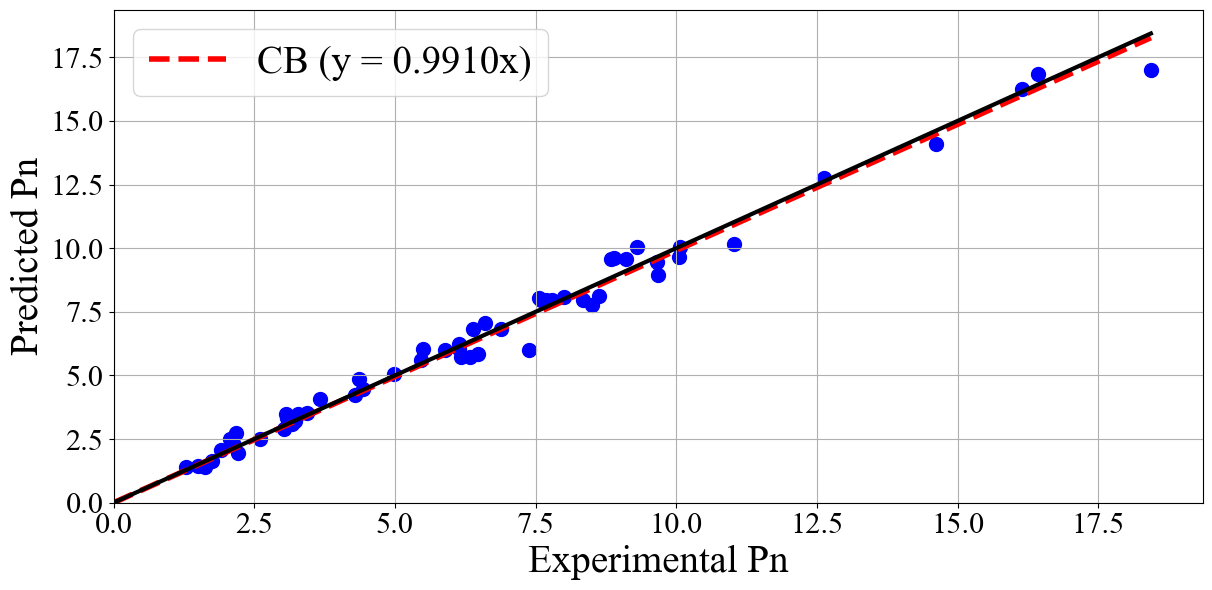

In [4]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Reshape to 2D array
pred_orig = scaler_y.inverse_transform(y_pred_val.reshape(-1, 1))  # Reshape to 2D array
# Fit linear regression through origin (y = mx)
reg = LinearRegression(fit_intercept=False)
reg.fit(y_test_orig, pred_orig)
m = reg.coef_[0][0]

# Prepare data for lines
line_x = np.linspace(0, max(y_test_orig.max(), pred_orig.max()), 100)
line_y = m * line_x
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
# Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test_orig, pred_orig, color='blue',s=100)
plt.plot(line_x, line_y, 'r--', label=f'CB (y = {m:.4f}x)', linewidth=4)
plt.plot(line_x, line_x, 'k-',linewidth=3)
plt.xlabel('Experimental Pn',fontsize=28)
plt.ylabel('Predicted Pn',fontsize=28)
plt.legend(fontsize=28)
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
# Change font size for axis ranges (tick labels)
plt.tick_params(axis='both', labelsize=22)  # Change font size of both x and y ticks
plt.tight_layout()
plt.savefig('CB', dpi=300)
plt.show()

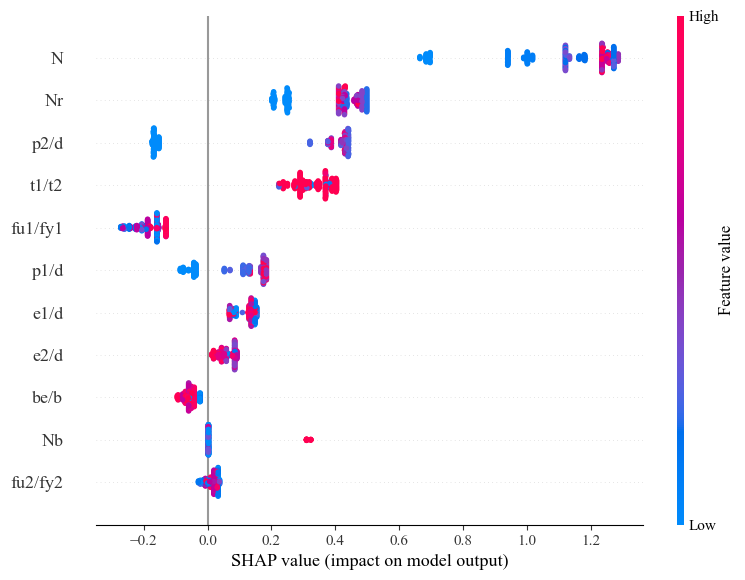

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6088\2366145643.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_abs_shap, x='Mean |SHAP|', y='Feature', palette='viridis')


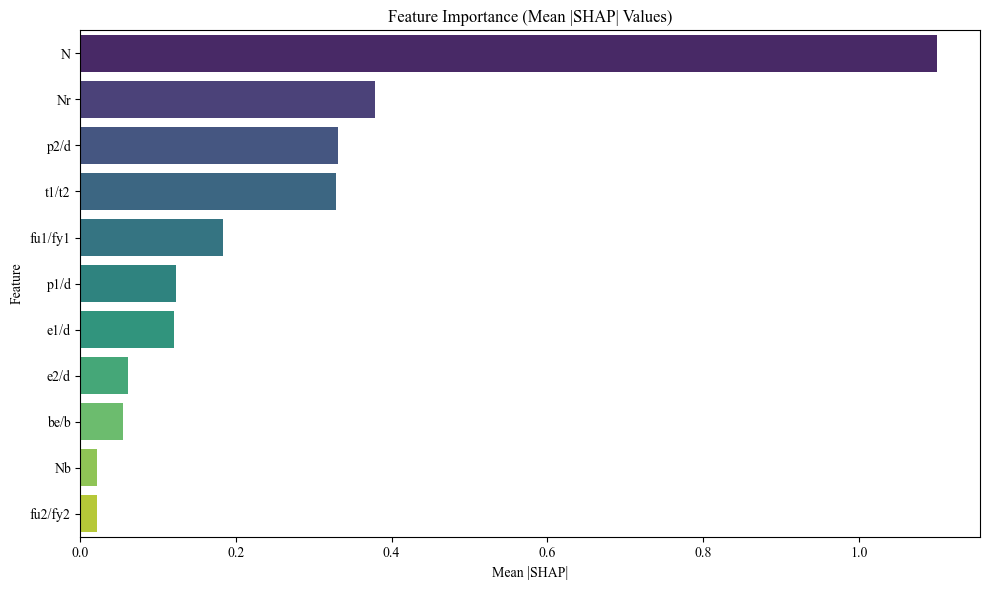

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6088\2366145643.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_abs_shap, x='Mean |SHAP|', y='Feature', palette='viridis')


In [4]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
# SHAP Explainer
explainer = shap.Explainer(final_model)
shap_values = explainer(X)

# --- SHAP Summary Plot ---
shap.summary_plot(shap_values, X)

# --- Mean Absolute SHAP Value Plot ---
mean_abs_shap = pd.DataFrame({
    'Feature': X.columns,
    'Mean |SHAP|': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='Mean |SHAP|', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_abs_shap, x='Mean |SHAP|', y='Feature', palette='viridis')
plt.title('Feature Importance (Mean |SHAP| Values)')
plt.tight_layout()
plt.show()

# --- Save SHAP Summary Plot ---
plt.figure()
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=600, bbox_inches='tight')
plt.close()

# --- Save Mean |SHAP| Bar Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_abs_shap, x='Mean |SHAP|', y='Feature', palette='viridis')
plt.title('Feature Importance (Mean |SHAP| Values)')
plt.tight_layout()
plt.savefig("mean_abs_shap_importance.png", dpi=600, bbox_inches='tight')
plt.close()




In [5]:
output_file = "catboost_model.joblib"
joblib.dump((final_model, scaler_X, scaler_y), output_file)

print(f"Model and scalers saved to {output_file}")

Model and scalers saved to catboost_model.joblib


In [6]:
import numpy as np

def calculate_taylor_stats(observed, predicted):
    """
    Calculate Taylor diagram statistics:
    correlation coefficient (R), centered RMS difference (RMSD), and predicted std deviation (sigma).
    """
    obs_mean = np.mean(observed)
    pred_mean = np.mean(predicted)
    
    obs_centered = observed - obs_mean
    pred_centered = predicted - pred_mean
    
    sigma_pred = np.std(pred_centered, ddof=1)
    R = np.corrcoef(observed, predicted)[0, 1]
    RMSD = np.sqrt(np.mean((pred_centered - obs_centered)**2))
    
    return R, RMSD, sigma_pred

# Inverse transform true and predicted test values to original scale
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
y_pred_orig = scaler_y.inverse_transform(y_pred_val.reshape(-1, 1)).ravel()

# Calculate Taylor diagram stats for the final model
R, RMSD, sigma_pred = calculate_taylor_stats(y_test_orig, y_pred_orig)

print("\nTaylor Diagram Statistics for Final Model on Test Data:")
print(f"Correlation coefficient (R): {R:.4f}")
print(f"Centered RMS difference (RMSD): {RMSD:.4f}")
print(f"Predicted standard deviation (σ): {sigma_pred:.4f}")



Taylor Diagram Statistics for Final Model on Test Data:
Correlation coefficient (R): 0.9929
Centered RMS difference (RMSD): 0.4719
Predicted standard deviation (σ): 3.8585


In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the existing image
image_path = shap_summary_plot.png"
img = mpimg.imread(image_path)

# Create a new figure and display the image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
ax.axis('off')  # Turn off axes for cleaner look

# Add text with subscripts and superscripts
# Example: Adding a label at a specific position
ax.text(300, 100, r'$f_{u1}/f_{y1}$', fontsize=14, color='black')  # Example with subscript
ax.text(300, 200, r'$e^{2}/d$', fontsize=14, color='black')        # Example with superscript
ax.text(300, 300, r'$N_{b}$', fontsize=14, color='black')          # Subscript example

# Save the updated image
output_path = "shap_summary_plot_with_text.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

output_path


SyntaxError: unterminated string literal (detected at line 5) (3580125455.py, line 5)

In [7]:
joblib.dump(final_model, 'final_model.pkl')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


['scaler_y.pkl']